# Strategy

In this notebook, we attempt to train an inverse dynamics model (IDM). In Reinforcement Learning parlance, an IDM learns to predict $a_t$ given $s_t$ and $s_{t+1}$. In our case, we have access to the MetaDrive simulator and the Waymo dataset. We want to predict the action the car should take in MetaDrive so that the successor state in the simulator is as close as possible to the successor state in the Waymo dataset.

In [1]:
import typing
from dataclasses import dataclass
import numpy as np
import numpy.typing as npt

@dataclass
class State:
    heading: float
    velocity: npt.NDArray[np.float64]


Observation: typing.TypeAlias = tuple[State, State]
Action: typing.TypeAlias = tuple[float, float]

In [92]:
from waymo_protos import scenario_pb2
# tensorflow don't allocate all gpu memory right away
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import tensorflow as tf


def getFiles(path: str) -> list[str]:
    path = os.path.expanduser(path)
    files = [os.path.join(path, f) for f in os.listdir(path)]
    return [f for f in files if os.path.isfile(f)]


files = getFiles('~/data/waymo/')

def parse_scenario(scenario: scenario_pb2.Scenario) -> list[State]:
    states = []
    for s in scenario.tracks[scenario.sdc_track_index].states:
        if s.valid:
            states.append(State(s.heading, np.array([s.velocity_x, s.velocity_y], dtype=np.float32)))
    return states


trajectories: list[list[State]] = []

file_iter = iter(files)

In [93]:
for file_path in file_iter:
    trajectories_in_file = []
    for data in tf.data.TFRecordDataset(file_path, compression_type="").as_numpy_iterator():
        scenario = scenario_pb2.Scenario()
        scenario.ParseFromString(data)
        trajectories_in_file.append(parse_scenario(scenario))
    trajectories.extend(trajectories_in_file)
    print(f"Loaded {len(trajectories_in_file)} trajectories from {file_path}")

Loaded 78 trajectories from /home/fidgetsinner/data/waymo/training_20s.tfrecord-00069-of-01000
Loaded 78 trajectories from /home/fidgetsinner/data/waymo/training_20s.tfrecord-00086-of-01000
Loaded 57 trajectories from /home/fidgetsinner/data/waymo/training_20s.tfrecord-00008-of-01000
Loaded 69 trajectories from /home/fidgetsinner/data/waymo/training_20s.tfrecord-00046-of-01000
Loaded 95 trajectories from /home/fidgetsinner/data/waymo/training_20s.tfrecord-00097-of-01000
Loaded 64 trajectories from /home/fidgetsinner/data/waymo/training_20s.tfrecord-00096-of-01000
Loaded 66 trajectories from /home/fidgetsinner/data/waymo/training_20s.tfrecord-00013-of-01000
Loaded 77 trajectories from /home/fidgetsinner/data/waymo/training_20s.tfrecord-00023-of-01000
Loaded 70 trajectories from /home/fidgetsinner/data/waymo/training_20s.tfrecord-00089-of-01000
Loaded 72 trajectories from /home/fidgetsinner/data/waymo/training_20s.tfrecord-00035-of-01000
Loaded 88 trajectories from /home/fidgetsinner/dat

KeyboardInterrupt: 

In [99]:
import pickle
import os
import lzma

# pickle the trajectories
if not os.path.exists('waymo_data/trajectories.pkl.xz'):
    with lzma.open('waymo_data/trajectories.pkl.xz', 'wb') as f:
        pickle.dump(trajectories, f)

In [103]:
import pickle
import os
import lzma

# unpickle and decompress
if "trajectories" not in locals():
    with lzma.open('waymo_data/trajectories.pkl.xz', 'rb') as f:
        trajectories = pickle.load(f)

In [100]:
import random

idm_data: list[Observation] = []
for states in trajectories:
    for i in range(len(states)-1):
        idm_data.append((states[i], states[i+1]))

# 90:10 train-validation split
random.seed(0)
random.shuffle(idm_data)
idm_train_data = idm_data[:int(len(idm_data)*0.9)]
idm_validation_data = idm_data[int(len(idm_data)*0.9):]

In [101]:
print("train data:", len(idm_train_data))
print("validation data:", len(idm_validation_data))

train data: 399502
validation data: 44390


In [4]:
import matplotlib.pyplot as plt
import metadrive
from metadrive import MetaDriveEnv
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F



def deviceof(m: nn.Module) -> torch.device:
    """
    Get the device of the given module
    """
    return next(m.parameters()).device

def normalize_angle(angle: float) -> float:
    """
    Normalize the angle to [-pi, pi)
    """
    return (angle + np.pi) % (2 * np.pi) - np.pi

def get_metadrive_state(env: MetaDriveEnv) -> State:
    return State(heading=env.vehicle.heading_theta, velocity=env.vehicle.velocity[:2])

def next_state(env: MetaDriveEnv, s: State, a: Action) -> State:
    """
    runs the policy and returns the total reward
    """
    # reset
    env.reset()
    env.vehicle.set_position(env.vehicle.position, height=0.49)

    # allow car to settle
    for _ in range(5):
        env.step([0,0])

    # set the initial state
    env.vehicle.set_velocity(s.velocity)
    env.vehicle.set_heading_theta(s.heading)
    
    # run the simulator
    env.step(a)

    # get the new state
    s_prime = get_metadrive_state(env)

    # allow car to settle (if rendering)
    if env.config.use_render:
        for _ in range(10):
            env.step([0,0])

    return s_prime

def gen_random_action() -> Action:
    """
    Generates a random action with probabilities that are similar to that are found in the waymo dataset
    """
    a = tuple(np.random.normal(0, 0.5, 2))
    return a

def state_batch_to_tensor(states: list[State], device: torch.device) -> torch.Tensor:
    """
    Reshape the state from State to a tensor of shape (batch_size, 3)
    """

    return torch.tensor(np.stack([
        [st.velocity[0], st.velocity[1], st.heading] for st in states
    ]), dtype=torch.float32, device=device)

def action_batch_to_tensor(actions: list[Action], device: torch.device) -> torch.Tensor:
    """
    Reshape the action from Action to a tensor of shape (batch_size, 2)
    """
    return torch.tensor(np.stack(actions), dtype=torch.float32, device=device)

def obs_batch_to_tensor(obs: list[Observation], device: torch.device) -> torch.Tensor:
    """
    Reshape the observation from tuple[State, State] to a tensor of shape (batch_size, 3, 2)
    """

    observations = []

    for st0, st1 in obs:
        observations.append(np.array([
            [st0.velocity[0], st1.velocity[0]], 
            [st0.velocity[1], st1.velocity[1]],
            [st0.heading, st1.heading]
        ]))

    return torch.tensor(np.stack(observations), dtype=torch.float32, device=device)

Successfully registered the following environments: ['MetaDrive-validation-v0', 'MetaDrive-10env-v0', 'MetaDrive-100envs-v0', 'MetaDrive-1000envs-v0', 'SafeMetaDrive-validation-v0', 'SafeMetaDrive-10env-v0', 'SafeMetaDrive-100envs-v0', 'SafeMetaDrive-1000envs-v0', 'MARLTollgate-v0', 'MARLBottleneck-v0', 'MARLRoundabout-v0', 'MARLIntersection-v0', 'MARLParkingLot-v0', 'MARLMetaDrive-v0'].


This task may take a few minutes to run the first time.

In [6]:
def generate_data(s0_batch: list[State]) -> list[tuple[State, Action, State]]:
    env = MetaDriveEnv(config={"on_continuous_line_done": False, "use_render": False})
    dataset: list[tuple[State, Action, State]] = []
    for s0 in s0_batch:
        a = gen_random_action()
        s1 = next_state(env, s0, a)
        dataset.append((s0, a, s1))
    env.close()
    return dataset

In [109]:
from concurrent.futures import ProcessPoolExecutor
from metadrive import MetaDriveEnv

MAX_WORKERS = 16

mm_train_data: list[tuple[State, Action, State]] = []

with ProcessPoolExecutor(max_workers=MAX_WORKERS) as executor:
    batch_size, leftover_size = divmod(len(idm_train_data), MAX_WORKERS)
    
    # Distribute the data evenly among workers
    n_scenarios_per_worker = [batch_size]*MAX_WORKERS
    n_scenarios_per_worker[0] += leftover_size

    # Distribute the initial states among workers
    idm_train_data_iter = iter(idm_train_data)
    s0_batch_per_worker = [[next(idm_train_data_iter)[0] for _ in range(n_scenarios)] for n_scenarios in n_scenarios_per_worker]

    # Generate the data in parallel
    for batch in executor.map(generate_data, s0_batch_per_worker):
        mm_train_data.extend(batch)

:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager
:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager
:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager
:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager
:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager
:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager
:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager
:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager
:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager
:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager
:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager
:task(warn

In [26]:
from concurrent.futures import ProcessPoolExecutor
from metadrive import MetaDriveEnv

MAX_WORKERS = 16

mm_validation_data: list[tuple[State, Action, State]] = []

with ProcessPoolExecutor(max_workers=MAX_WORKERS) as executor:
    batch_size, leftover_size = divmod(len(idm_validation_data), MAX_WORKERS)
    
    # Distribute the data evenly among workers
    n_scenarios_per_worker = [batch_size]*MAX_WORKERS
    n_scenarios_per_worker[0] += leftover_size

    # Distribute the initial states among workers
    idm_train_data_iter = iter(idm_train_data)
    s0_batch_per_worker = [[next(idm_train_data_iter)[0] for _ in range(n_scenarios)] for n_scenarios in n_scenarios_per_worker]

    # Generate the data in parallel
    for batch in executor.map(generate_data, s0_batch_per_worker):
        mm_validation_data.extend(batch)

:device(warning): /dev/input/event6 is not readable, some features will be unavailable.
:device(warning): /dev/input/event7 is not readable, some features will be unavailable.
:device(warning): /dev/input/event23 is not readable, some features will be unavailable.


In [29]:
import pickle
import os
import lzma

# pickle the data
if not os.path.exists('waymo_data/mm_train_data.pkl.xz'):
    with open('waymo_data/mm_train_data.pkl.xz', 'wb') as f:
        pickle.dump(mm_train_data, f)

if not os.path.exists('waymo_data/mm_validation_data.pkl.xz'):
    with open('waymo_data/mm_validation_data.pkl.xz', 'wb') as f:
        pickle.dump(mm_validation_data, f)



In [5]:
import pickle
import os
import lzma

if 'mm_train_data' not in locals():
    # load data (if exists)   
    with lzma.open('data/mm_train_data.pkl.xz', 'rb') as f:
        mm_train_data = pickle.load(f)

if 'mm_validation_data' not in locals():
    with lzma.open('data/mm_validation_data.pkl.xz', 'rb') as f:
        mm_validation_data = pickle.load(f)

In [102]:
print("training data:", len(mm_train_data))
print("validation data:", len(mm_validation_data))

training data: 147941
validation data: 11892


In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# create a model that attempts to predict the next state given the current state and the action: (throttle and steering)
# each state contains: velocity_x, velocity_y, and heading
class MetadriveModel(nn.Module):
    def __init__(self):
        super().__init__()
        # input shape: (batch_size, 3) + (batch_size, 2) = (batch_size, 5)
        # output shape: (batch_size, 3)
        self.fc1 = nn.Linear(5, 768)
        self.fc2 = nn.Linear(768, 768)
        self.fc3 = nn.Linear(768, 3)
    
    def forward(self, states: torch.Tensor, actions: torch.Tensor):
        # clip actions to be between -1 and 1
        actions = torch.clamp(actions, -1, 1)
        x = torch.cat([states, actions], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = x + states
        return x

def metadrive_model_train_batch(
    mm: MetadriveModel,
    mm_optimizer: torch.optim.Optimizer,
    s0_batch: list[State],
    a_batch: list[Action],
    s1_batch: list[State],
) -> float: 
    device = deviceof(mm)

    s0_tensor = state_batch_to_tensor(s0_batch, device) 
    a_tensor = action_batch_to_tensor(a_batch, device)
    s1_tensor = state_batch_to_tensor(s1_batch, device)

    mm_optimizer.zero_grad()
    s1_pred_tensor = mm(s0_tensor, a_tensor)
    loss = F.mse_loss(s1_pred_tensor, s1_tensor)
    loss.backward()
    mm_optimizer.step()
    return float(loss.item())



In [31]:
def set_lr(optimizer: torch.optim.Optimizer, lr: float) -> None:
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [64]:
import itertools
# make sure we don't run out of data
mm_train_iter = itertools.cycle(mm_train_data)

mm = MetadriveModel().to(device)

mm_optimizer = torch.optim.AdamW(mm.parameters())

mm_step = 0
mm_losses = []

In [69]:
set_lr(mm_optimizer, 1e-4)
METADRIVE_MODEL_TRAIN_EPOCHS = 20000
METADRIVE_MODEL_TRAIN_BATCH_SIZE = 8192

while mm_step < METADRIVE_MODEL_TRAIN_EPOCHS:
    # take up to n from the data buffer
    data_batch = [next(mm_train_iter) for _ in range(METADRIVE_MODEL_TRAIN_BATCH_SIZE)]
    # unpack the batch
    s0_batch, a_batch, s1_batch = zip(*data_batch)
    loss = metadrive_model_train_batch(mm, mm_optimizer, s0_batch, a_batch, s1_batch)
    mm_losses.append(loss)
    mm_step += 1
    if mm_step % 500 == 0:
        # print average loss over the last 500 steps
        loss = np.mean(mm_losses[-500:])
        print(f"Step: {mm_step}, Loss: {loss:.4f}")

Step: 11500, Loss: 0.0742
Step: 12000, Loss: 0.0734
Step: 12500, Loss: 0.0713
Step: 13000, Loss: 0.0693
Step: 13500, Loss: 0.0697
Step: 14000, Loss: 0.0672
Step: 14500, Loss: 0.0658
Step: 15000, Loss: 0.0641
Step: 15500, Loss: 0.0642
Step: 16000, Loss: 0.0640
Step: 16500, Loss: 0.0614
Step: 17000, Loss: 0.0649
Step: 17500, Loss: 0.0612
Step: 18000, Loss: 0.0604
Step: 18500, Loss: 0.0608
Step: 19000, Loss: 0.0602
Step: 19500, Loss: 0.0596
Step: 20000, Loss: 0.0576


In [120]:
# load mm
if 'mm' not in locals():
    mm = MetadriveModel().to(device)
    mm.load_state_dict(torch.load('data/mm.pth'))

In [118]:
# save mm
if not os.path.exists('data/mm.pth'):
    torch.save(mm.state_dict(), 'data/mm.pth')

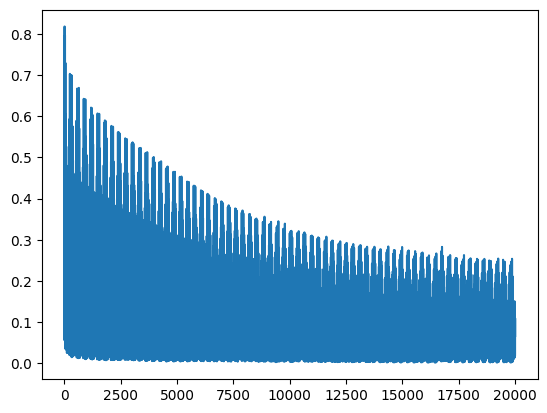

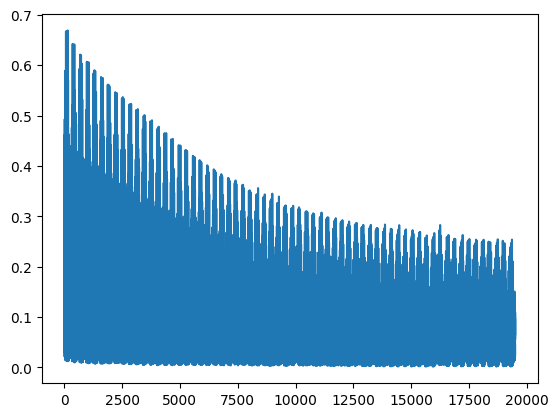

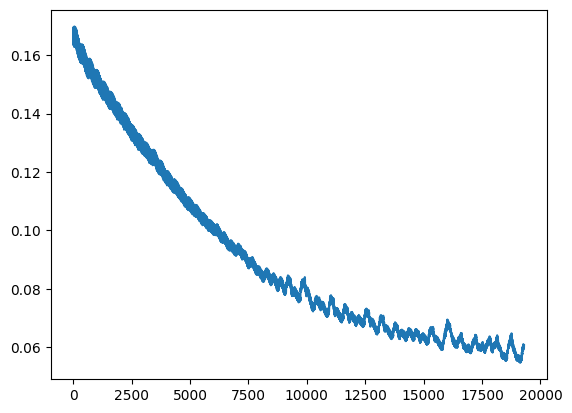

In [70]:
import matplotlib.pyplot as plt

# Plot the losses over training
plt.plot(list(range(len(mm_losses))), mm_losses, label='MM')
plt.show()

latter_training = mm_losses[500:]
plt.plot(list(range(len(latter_training))), latter_training, label='MM')
plt.show()

# running average of last 200 losses
latter_training_averaged = np.convolve(latter_training, np.ones((200,))/200, mode='valid')
plt.plot(list(range(len(latter_training_averaged))), latter_training_averaged, label='MM')
plt.show()

In [71]:
s0_batch = [s0 for s0, _, _ in mm_train_data]
s1_batch = [s1 for _, _, s1 in mm_train_data]
a_batch = [a for _, a, _ in mm_train_data]

s0_tensor = state_batch_to_tensor(s0_batch, device)
s1_tensor = state_batch_to_tensor(s1_batch, device)
a_tensor = action_batch_to_tensor(a_batch, device)

s1_pred = mm(s0_tensor, a_tensor)

loss = (s1_pred - s1_tensor)**2
loss_x = loss[:, 0]
loss_y = loss[:, 1]
loss_theta = loss[:, 2]

print("training loss", loss.mean().item())

training loss 0.05709254741668701


In [72]:
s0_batch = [s0 for s0, _, _ in mm_validation_data]
s1_batch = [s1 for _, _, s1 in mm_validation_data]
a_batch = [a for _, a, _ in mm_validation_data]

s0_tensor = state_batch_to_tensor(s0_batch, device)
s1_tensor = state_batch_to_tensor(s1_batch, device)
a_tensor = action_batch_to_tensor(a_batch, device)

s1_pred = mm(s0_tensor, a_tensor)

loss = (s1_pred - s1_tensor)**2
loss_x = loss[:, 0]
loss_y = loss[:, 1]
loss_theta = loss[:, 2]

print("validation loss", loss.mean().item())

validation loss 0.09112946689128876


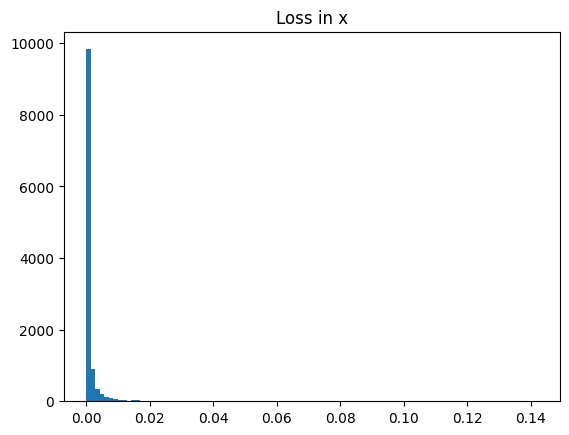

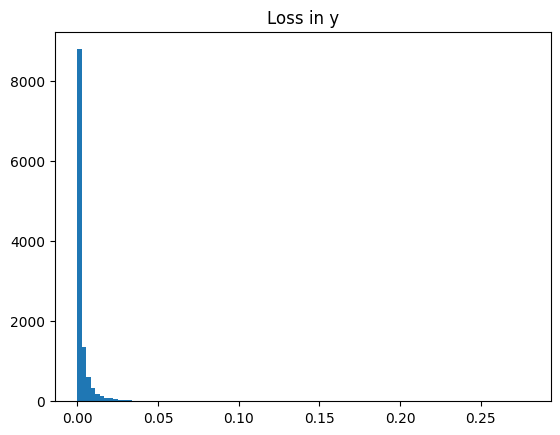

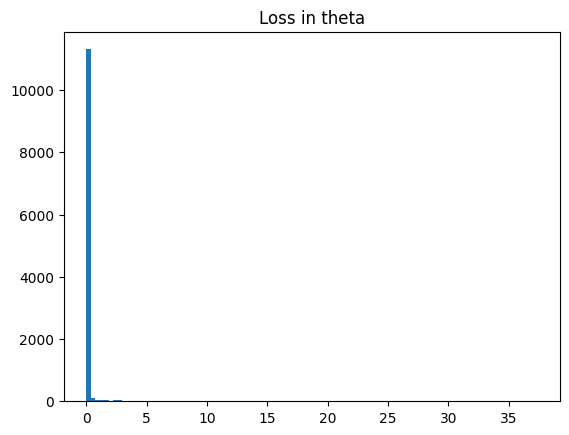

In [73]:
plt.hist(loss_x.cpu().detach().numpy(), bins=100)
plt.title('Loss in x')
plt.show()
plt.hist(loss_y.cpu().detach().numpy(), bins=100)
plt.title('Loss in y')
plt.show()
plt.hist(loss_theta.cpu().detach().numpy(), bins=100)
plt.title('Loss in theta')
plt.show()


Now that we have trained a neural network model of Metadrive through which we can backprop, training the IDM is easy.

In [57]:
# creates a model that attempts to predict the action given the current state and the next state
class InverseDynamicsModel(nn.Module):
    def __init__(self):
        super().__init__()
        # input shape: (batch_size, 3, 2)
        # output shape: (batch_size, 2)

        self.conv1 = nn.Conv1d(3, 768, 2) # Bx3x2 -> Bx768x1
        self.fc1 = nn.Linear(768, 768) # Bx768 -> Bx768
        self.fc2 = nn.Linear(768, 2) # Bx768 -> Bx2
    
    def forward(self, x: torch.Tensor):
        x = F.relu(self.conv1(x)) # Bx3x2 -> Bx768x1
        x = torch.flatten(x, 1) # Bx768x1 -> Bx768
        x = F.relu(self.fc1(x)) # Bx768 -> Bx768
        x = self.fc2(x) # Bx768 -> Bx2
        return x

def idm_train_batch(
        mm: MetadriveModel,
        idm: InverseDynamicsModel,
        idm_optimizer: torch.optim.Optimizer,
        obs_batch: list[Observation],
) -> float:
    device = deviceof(mm)

    assert deviceof(idm) == device

    obs_tensor = obs_batch_to_tensor(obs_batch, device)
    s0_tensor = state_batch_to_tensor([s0 for s0, _ in obs_batch], device)
    s1_tensor = state_batch_to_tensor([s1 for _, s1 in obs_batch], device)

    idm_optimizer.zero_grad()

    pred_action = idm(obs_tensor)
    pred_s1 = mm(s0_tensor, pred_action)

    loss = F.mse_loss(pred_s1, s1_tensor)
    loss.backward()

    idm_optimizer.step()

    return float(loss.item())

In [58]:
# eliminate outliers from the training data
idm_train_data_filtered = [o for o in idm_train_data if np.linalg.norm(o[1].velocity - o[0].velocity) < 1 and abs(normalize_angle(o[1].heading - o[0].heading)) < 0.2] 
print(len(idm_train_data_filtered))

147898


In [59]:
idm_train_iter = itertools.cycle(idm_train_data_filtered)

idm = InverseDynamicsModel().to(device)

idm_optimizer = torch.optim.AdamW(idm.parameters())

idm_step = 0
idm_losses = []

In [90]:
set_lr(idm_optimizer, 5e-5)
INVERSE_DYNAMICS_MODEL_TRAIN_EPOCHS = 20000
INVERSE_DYNAMICS_MODEL_TRAIN_BATCH_SIZE = 8192

while idm_step < INVERSE_DYNAMICS_MODEL_TRAIN_EPOCHS:
    obs_batch = [next(idm_train_iter) for _ in range(INVERSE_DYNAMICS_MODEL_TRAIN_BATCH_SIZE)]
    loss = idm_train_batch(
        mm,
        idm,
        idm_optimizer,
        obs_batch,
    )
    idm_losses.append(loss)
    idm_step += 1
    if idm_step % 100 == 0:
        print(f"Step: {idm_step}, Loss: {loss:.4f}")

Step: 5000, Loss: 0.1902
Step: 5100, Loss: 0.0384
Step: 5200, Loss: 0.0636
Step: 5300, Loss: 0.0276
Step: 5400, Loss: 0.0794
Step: 5500, Loss: 0.1482
Step: 5600, Loss: 0.0316
Step: 5700, Loss: 0.0613


KeyboardInterrupt: 

In [31]:
# load idm
if 'idm' not in locals():
    idm = InverseDynamicsModel().to(device)
    idm.load_state_dict(torch.load('data/idm.pth'))    

In [178]:
# save idm
if not os.path.exists('data/idm.pth'):
    torch.save(mm.state_dict(), 'data/idm.pth')

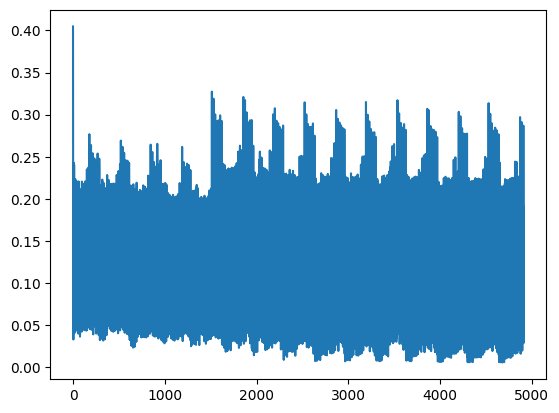

In [75]:
import matplotlib.pyplot as plt

# Plot the losses over training
plt.plot(list(range(len(idm_losses))), idm_losses, label='IDM')
plt.show()

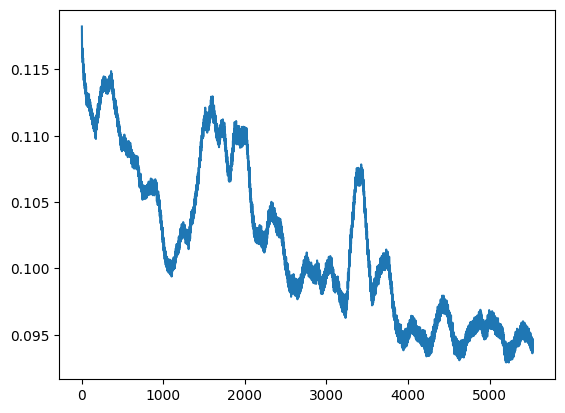

In [91]:
# compute running average of the last 200 episodes
# plot the average reward per episode
idm_losses_averaged = np.convolve(idm_losses, np.ones((200,))/200, mode='valid')
plt.plot(idm_losses_averaged)

Let' compare our trained IDM against the null idm (predicts 0 for all values):

In [77]:
obs_batch = idm_train_data

obs_tensor = obs_batch_to_tensor(obs_batch, device)
s0_tensor = state_batch_to_tensor([s0 for s0, _ in obs_batch], device)
s1_tensor = state_batch_to_tensor([s1 for _, s1 in obs_batch], device)
with torch.no_grad():
    action_pred = idm(obs_tensor)
    s1_pred = mm(s0_tensor, action_pred)

loss = (s1_pred - s1_tensor)**2
loss_x = loss[:, 0].cpu().detach().numpy()
loss_y = loss[:, 1].cpu().detach().numpy()
loss_theta = loss[:, 2].cpu().detach().numpy()

print("training loss", loss.mean().item())

training loss 0.09605647623538971


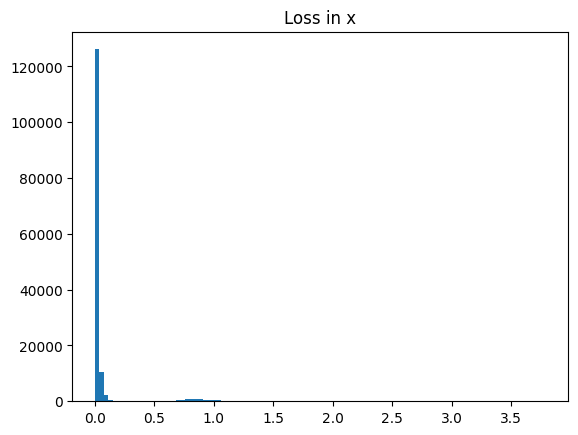

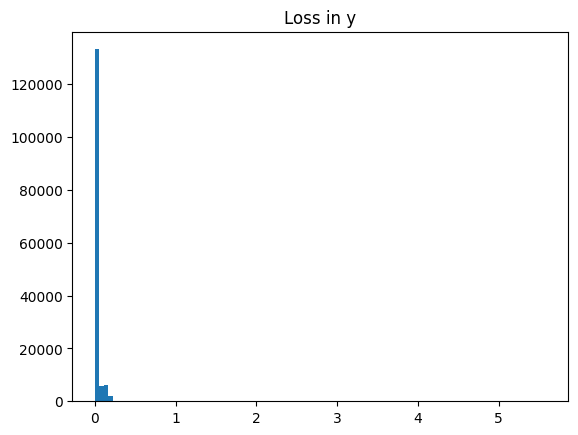

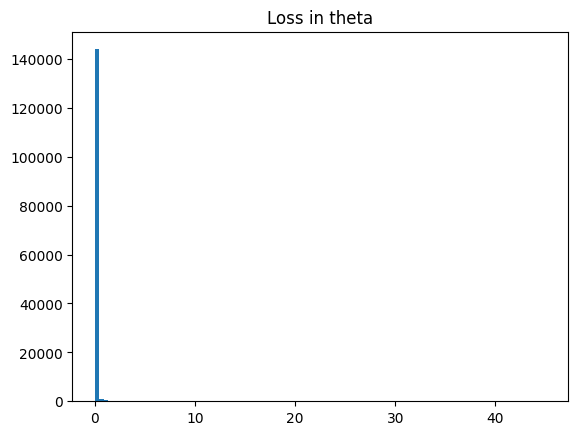

In [78]:
plt.hist(loss_x, bins=100)
plt.title('Loss in x')
plt.show()
plt.hist(loss_y, bins=100)
plt.title('Loss in y')
plt.show()
plt.hist(loss_theta, bins=100)
plt.title('Loss in theta')
plt.show()


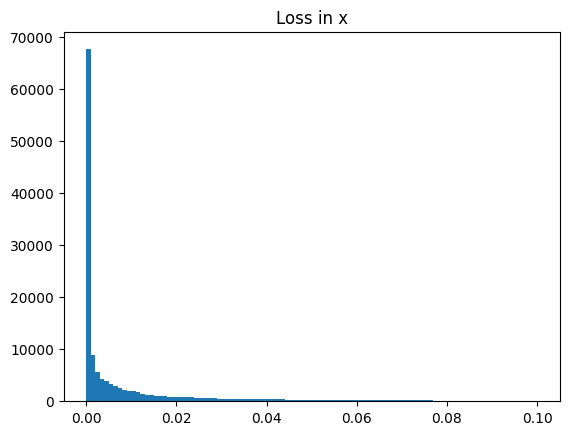

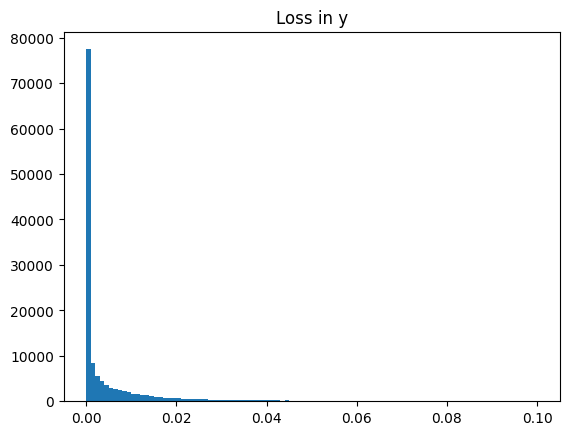

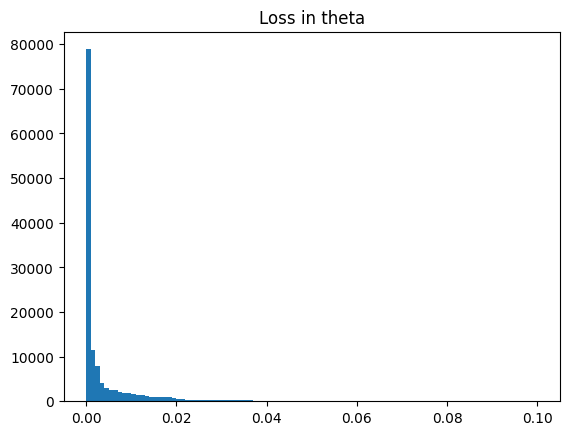

In [79]:
loss_x_no_outliers = np.array([x for x in loss_x if x < 0.1 ]) 
loss_y_no_outliers = np.array([x for x in loss_y if x < 0.1 ])
loss_theta_no_outliers = np.array([x for x in loss_theta if x < 0.1 ])

plt.hist(loss_x_no_outliers, bins=100)
plt.title('Loss in x')
plt.show()
plt.hist(loss_y_no_outliers, bins=100)
plt.title('Loss in y')
plt.show()
plt.hist(loss_theta_no_outliers, bins=100)
plt.title('Loss in theta')
plt.show()


Let's try visualizing our IDM by having it follow a track from start to finish.

In [86]:
class IDMPolicy:
    def __init__(self, net: InverseDynamicsModel):
        self.net = net

    def __call__(self, obs:Observation) -> Action:
        # sample an action from the policy network
        obs_tensor = obs_batch_to_tensor([obs], deviceof(self.net))
        # sample an action from the policy network
        with torch.no_grad():
            steering, throttle = self.net(obs_tensor)[0]
        return steering.item(), throttle.item()


In [163]:
env = gym.make("MetaDrive-validation-v0", config={"on_continuous_line_done": False, "use_render": True})

In [164]:
scenario = h[1]
with torch.no_grad():
    # reset
    env.reset()

    # allow car to settle
    for _ in range(10):
        env.step([0,0])

    st = scenario[0]

    # set the initial state
    env.vehicle.set_velocity(st.velocity)
    env.vehicle.set_heading_theta(st.heading)


    for i in range(len(scenario)-1):
        st0 = scenario[i]
        st1 = scenario[i+1]
        st0_pred = get_metadrive_state(env)
        action = IDMPolicy(idm)((st0, st1))
        env.step(action)
        st1_pred = get_metadrive_state(env)
        print(action)
        print(st1_pred.velocity, st1_pred.heading, st1.velocity, st1.heading)
        

NameError: name 'h' is not defined

In [108]:
env.close()

In [107]:
env = MetaDriveEnv(config={"on_continuous_line_done": False, "use_render": False})

In [81]:
def compute_loss(s_pred: State, s_true:State) -> float:
    """
    Computes the loss between the predicted state and the true state
    """
    vel_error = np.linalg.norm(s_pred.velocity - s_true.velocity) ** 2
    heading_error = normalize_angle(s_pred.heading - s_true.heading) ** 2
    return float(vel_error + heading_error)


def run_game(env: MetaDriveEnv, policy:typing.Callable[[Observation], Action], o: Observation) -> tuple[Action, float, State]:
    s0, s1 = o
    a = policy(o)
    s1_pred = next_state(env, s0, a)
    r = -compute_loss(s1, s1_pred)
    return a, r, s1_pred

def run_game_est(mm:MetadriveModel, policy:typing.Callable[[Observation], Action], o: Observation) -> tuple[Action, float, State]:
    device = deviceof(mm)
    s0, s1 = o
    a = policy(o)
    with torch.no_grad():
        s1_pred_tensor = mm(state_batch_to_tensor([s0],device), action_batch_to_tensor([a],device)).detach().cpu().numpy()[0]
    s1_pred = State(velocity=s1_pred_tensor[:2], heading=s1_pred_tensor[2])
    r = -compute_loss(s1, s1_pred)
    return a, r, s1_pred


In [82]:
import random
idm_test_set = random.sample(idm_train_data, 500)

:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager


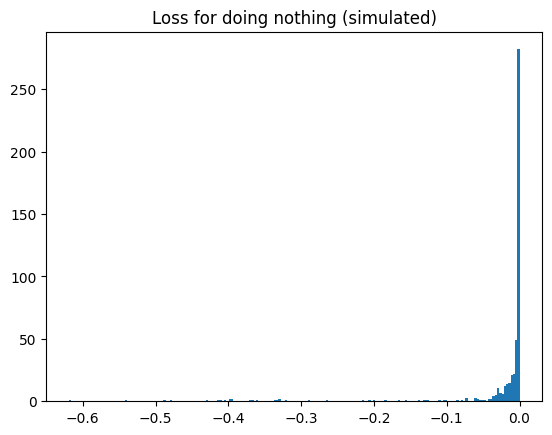

mean -0.028031828549420965
median -0.0018014580644578344


In [83]:
def null_policy(_:Observation) -> tuple[float, float]:
    return 0, 0

# test loss function
do_nothing_loss = []
for s0, s1 in idm_test_set:
    _, rew, _ = run_game(env, null_policy, (s0, s1))
    do_nothing_loss.append(rew)

plt.title("Loss for doing nothing (simulated)")
plt.hist(do_nothing_loss, bins=200)
plt.show()
print("mean", np.mean(do_nothing_loss))
print("median", np.median(do_nothing_loss))

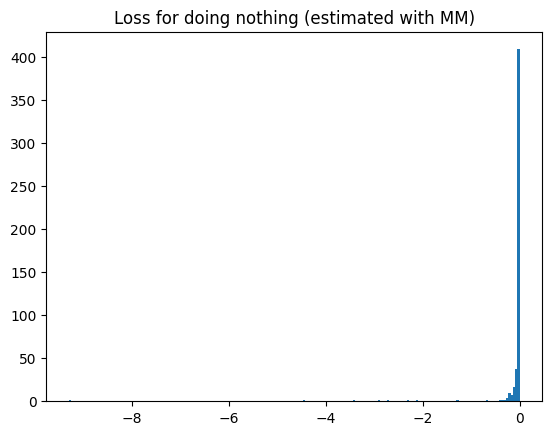

mean -0.09312820377986125
median -0.007985729904530791


In [84]:
# test loss function
do_nothing_loss_est = []
for s0, s1 in idm_test_set:
    _, rew, _ = run_game_est(mm, null_policy, (s0, s1))
    do_nothing_loss_est.append(rew)

plt.title("Loss for doing nothing (estimated with MM)")
plt.hist(do_nothing_loss_est, bins=200)
plt.show()
print("mean", np.mean(do_nothing_loss_est))
print("median", np.median(do_nothing_loss_est))

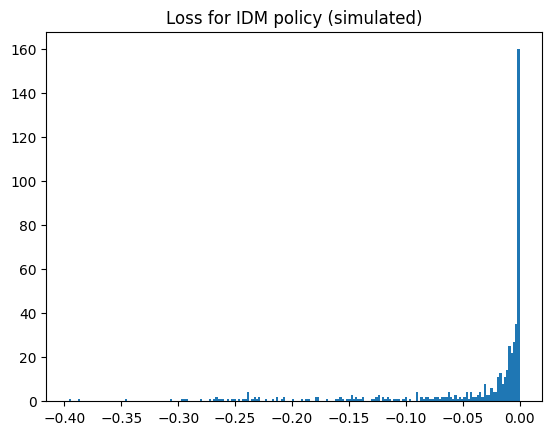

mean -0.04428656659200239
median -0.008229361601828246


In [127]:
# test loss function
idm_loss = []
for s0, s1 in idm_test_set:
    _, rew, _ = run_game(env, IDMPolicy(idm), (s0, s1))
    idm_loss.append(rew)

plt.title("Loss for IDM policy (simulated)")
plt.hist(idm_loss, bins=200)
plt.show()
print("mean", np.mean(idm_loss))
print("median", np.median(idm_loss))

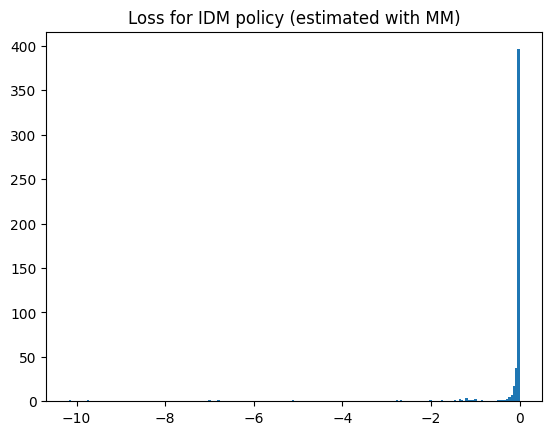

mean -0.17133533737554377
median -0.007309777606773982


In [87]:
# test loss function
idm_loss_est = []
for s0, s1 in idm_test_set:
    _, rew, _ = run_game_est(mm, IDMPolicy(idm), (s0, s1))
    idm_loss_est.append(rew)

plt.title("Loss for IDM policy (estimated with MM)")
plt.hist(idm_loss_est, bins=200)
plt.show()
print("mean", np.mean(idm_loss_est))
print("median", np.median(idm_loss_est))

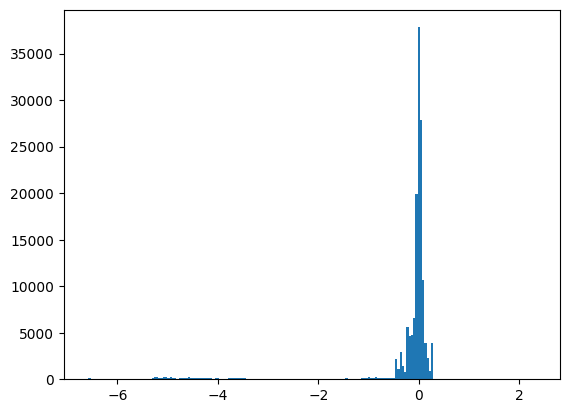

In [88]:
plt.hist(action_pred[:, 0].cpu().detach().numpy(), bins=200)
plt.show()

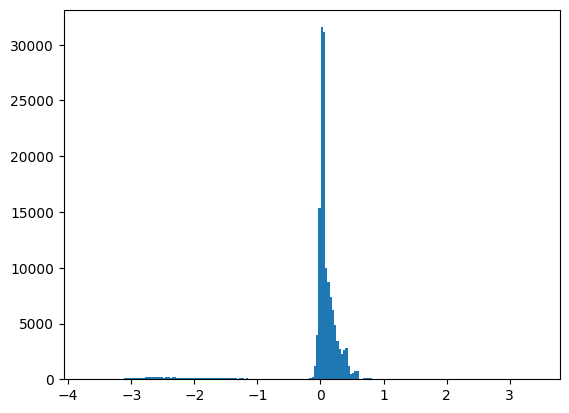

In [89]:
plt.hist(action_pred[:, 1].cpu().detach().numpy(), bins=200)
plt.show()